In [1]:
import numpy as np

def f(x):
    return(np.array([x[0]**2, x[1]**2]))

def grad_finite_diff(function, w, eps=1e-8):
    """
    Возвращает численное значение градиента, подсчитанное по следующией формуле:
        result_i := (f(w + eps * e_i) - f(w)) / eps,
        где e_i - следующий вектор:
        e_i = (0, 0, ..., 0, 1, 0, ..., 0)
                          >> i <<
    """
    e_i = np.zeros(len(w))
    grad = np.zeros(len(w))
    for i in range(len(w)):
        e_i[i] = 1
        result_i = (function(w + eps * e_i) - function(w)) / eps
        grad[i] += result_i[i]
        e_i[i] = 0
    return grad

grad_finite_diff(f, [5,2])

array([10.00000012,  3.99999998])

In [2]:
import numpy as np
import scipy
import time
from scipy.special import expit, logsumexp

class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """
    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')

        
class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """
    
    def __init__(self, l2_coef):
        """
        Задание параметров оракула.
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.l2_coef = l2_coef
    
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        loss = np.logaddexp(0, (-y * X.dot(w))).mean() + (self.l2_coef / 2) * (w ** 2).sum()
        return loss
    
    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        grad = X.T.dot((expit(y * X.dot(w)) - 1) * y) / X.shape[0] + self.l2_coef * w
        return grad
    

In [66]:
class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    def __init__(self, loss_function, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
                
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию.
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если (f(x_{k+1}) - f(x_{k})) < tolerance: то выход 
        
        max_iter - максимальное число итераций     
        
        **kwargs - аргументы, необходимые для инициализации   
        """
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.trashhold = 0.5
        if 'l2_coef' in kwargs.keys():
            self.l2_coef = kwargs.pop('l2_coef')
        else:
            self.l2_coef = 0
        if 'iter_acc' in kwargs.keys():
            self.iter_acc = kwargs.pop('iter_acc')
        else:
            self.iter_acc = 0
        if 'w_0' in kwargs.keys():
            self.w_0 = w_0
              
    @staticmethod
    def loss_bc(X, y, w, l2_coef):
        loss = np.logaddexp(0, (-y*X.dot(w))).mean() + (l2_coef/2)*(w**2).sum()
        return loss
    
    def fit(self, X, y, w_0=None, trace=False, x_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w_0 - начальное приближение в методе
        
        trace - переменная типа bool
      
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)
        
        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        if w_0 is None:
            w_0 = np.zeros(X.shape[1])
        self.w = w_0.copy()
        if trace == True:
            history = {'time': [0], 'func': [self.loss_bc(X, y, self.w, self.l2_coef)]}
            if self.iter_acc is True:
                acc = [self.accuracy(x_test, y_test)]
            start_time = time.time()
        for k in range(1, self.max_iter+1):
            if k>2 and self.tolerance != 0:
                if np.abs(history['func'][-2] - history['func'][-1]) < self.tolerance:
                    break
            nu = self.step_alpha / (k**self.step_beta)
            gradient = self.get_gradient(X, y)
            #self.w[0] = self.w[0] - nu * gradient[0]
            #self.w[1:] = self.w[1:] - (nu * gradient[1:] + (self.l2_coef/2 * self.w[1:]))
            self.w -= nu *gradient
            w_l = self.w
            if trace == True:
                history['time'].append(time.time() - start_time)
                loss = self.loss_bc(X, y, self.w, self.l2_coef)
                history['func'].append(loss)
                if self.iter_acc is True:
                    acc.append(self.accuracy(x_test, y_test))
                start_time = time.time()
        if trace == True:
            if self.iter_acc == True:
                return history, acc
            else:
                return history
        
    def predict(self, X):
        """
        Получение меток ответов на выборке X
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: одномерный numpy array с предсказаниями
        """
        return np.where((expit(X.dot(self.w)) >= self.trashhold) == True, 1, -1)

    def predict_proba(self, X):
        """
        Получение вероятностей принадлежности X к классу k
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        return: двумерной numpy array, [i, k] значение соответветствует вероятности
        принадлежности i-го объекта к классу k 
        """
        
        return np.sign(np.dot(self.w, X.transpose()))
        
        
    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: float
        """
        pass
        
    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array
        
        return: numpy array, размерность зависит от задачи
        """
        return X.T.dot((expit(y*X.dot(self.w))-1)*y)/X.shape[0] + self.l2_coef * self.w
    
    def get_weights(self):
        """
        Получение значения весов функционала
        """    
        return self.w

    def accuracy(self, X, y_true):
        y_pred = self.predict(X)
        return (y_pred == y_test).sum() / len(y_test)

In [81]:
class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """
    
    def __init__(self, loss_function, batch_size, step_alpha=1, step_beta=0, 
                 tolerance=1e-5, max_iter=1000, random_seed=153, **kwargs):
        """
        loss_function - строка, отвечающая за функцию потерь классификатора. 
        Может принимать значения:
        - 'binary_logistic' - бинарная логистическая регрессия
        
        batch_size - размер подвыборки, по которой считается градиент
        
        step_alpha - float, параметр выбора шага из текста задания
        
        step_beta- float, параметр выбора шага из текста задания
        
        tolerance - точность, по достижении которой, необходимо прекратить оптимизацию
        Необходимо использовать критерий выхода по модулю разности соседних значений функции:
        если (f(x_{k+1}) - f(x_{k})) < tolerance: то выход 
        
        
        max_iter - максимальное число итераций
        
        random_seed - в начале метода fit необходимо вызвать np.random.seed(random_seed).
        Этот параметр нужен для воспроизводимости результатов на разных машинах.
        
        **kwargs - аргументы, необходимые для инициализации
        """
        self.loss_function = loss_function
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.rand_seed = random_seed
        self.batch_size = batch_size
        self.l2_coef = kwargs.pop('l2_coef')
        self.trashhold = 0.5
        if 'l2_coef' in kwargs.keys():
            self.l2_coef = kwargs.pop('l2_coef')
        else:
            self.l2_coef = 0
        if 'iter_acc' in kwargs.keys():
            self.iter_acc = kwargs.pop('iter_acc')
        else:
            self.iter_acc = 0
        if 'w_0' in kwargs.keys():
            self.w_0 = w_0
            
    def fit(self, X, y, w_0=None, trace=False, log_freq=1, x_test=None, y_test=None):
        """
        Обучение метода по выборке X с ответами y
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
                
        w_0 - начальное приближение в методе
        
        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Если обновлять history после каждой итерации, метод перестанет 
        превосходить в скорости метод GD. Поэтому, необходимо обновлять историю метода лишь
        после некоторого числа обработанных объектов в зависимости от приближённого номера эпохи.
        Приближённый номер эпохи:
            {количество объектов, обработанных методом SGD} / {количество объектов в выборке}
        
        log_freq - float от 0 до 1, параметр, отвечающий за частоту обновления. 
        Обновление должно проиходить каждый раз, когда разница между двумя значениями приближённого номера эпохи
        будет превосходить log_freq.
        
        history['epoch_num']: list of floats, в каждом элементе списка будет записан приближённый номер эпохи:
        history['time']: list of floats, содержит интервалы времени между двумя соседними замерами
        history['func']: list of floats, содержит значения функции после текущего приближённого номера эпохи
        history['weights_diff']: list of floats, содержит квадрат нормы разности векторов весов с соседних замеров
        (0 для самой первой точки)
        """
        np.random.seed(self.rand_seed)
        if w_0 is None:
            w_0 = np.zeros(X.shape[1])
        self.w = w_0.copy()
        w_l = self.w.copy()
        used_obj_c = 0
        epoch_num = 0
        if trace == True:
            history = {'time': [0], 'func': [self.loss_bc(X, y, self.w, self.l2_coef)],
                       'weights_diff': [0], 'epoch_num' : [0]}
            if self.iter_acc is True:
                acc = [self.accuracy(x_test, y_test)]
        start_time = time.time()
        for k in range(1 , self.max_iter):
            ind = np.random.randint(X.shape[0], size = self.batch_size)
            used_obj_c += self.batch_size
            epoch_num = used_obj_c/X.shape[0]
            if (trace == True) and (used_obj_c/X.shape[0] > log_freq):
                history['epoch_num'].append(epoch_num*len(history['epoch_num']))
                history['time'].append(time.time() - start_time)
                history['weights_diff'].append(((w_l - self.w)**2).sum())
                loss = self.loss_bc(X[ind], y[ind], self.w, self.l2_coef)
                history['func'].append(loss)
                if np.abs(history['func'][-2] - history['func'][-1]) < self.tolerance:
                    break
                if self.iter_acc is True:
                    acc.append(self.accuracy(x_test, y_test))
                w_l = self.w
                used_obj_c = 0
                start_time = time.time()  
            nu = self.step_alpha / (k**self.step_beta) 
            gradient = self.get_gradient(X[ind], y[ind])
            self.w -= nu * gradient
            #self.w[0] = self.w[0] - nu * gradient[0]
            #self.w[1:] = self.w[1:] - (nu * gradient[1:] + (l2coef/len(y) * self.w[1:]))
        if trace == True:
            if self.iter_acc == True:
                return history, acc
            else:
                return history

In [181]:
import pandas as pd
df_test1 = pd.read_csv('toxic_test.csv')
df_train1 = pd.read_csv('toxic_train.csv')

df_train1 = df_train1.drop(columns=['Unnamed: 0'])
df_test1 = df_test1.drop(columns=['Unnamed: 0'])

df_train1['comment_text'] = df_train1['comment_text'].str.lower()
df_test1['comment_text'] = df_test1['comment_text'].str.lower()

df_test1['comment_text'] = df_test1['comment_text'].str.replace(r'\W+', ' ')
df_train1['comment_text'] = df_train1['comment_text'].str.replace(r'\W+', ' ')


In [182]:
df_test1.shape

(20676, 2)

In [183]:
df_train1.shape

(52061, 2)

In [184]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.07, max_df=0.8)

x_train = vectorizer.fit_transform(df_train1['comment_text'])
x_test = vectorizer.transform(df_test1['comment_text'])

y_train = np.array([1 if ist else -1 for ist in df_train1['is_toxic']])
y_test = np.array([1 if ist else -1 for ist in df_test1['is_toxic']])


In [185]:
x_train.shape

(52061, 83)

In [186]:
x_test.shape

(20676, 83)

In [187]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, max_df=0.8)

x_train = vectorizer.fit_transform(df_train1['comment_text'])
x_test = vectorizer.transform(df_test1['comment_text'])

y_train = np.array([1 if ist else -1 for ist in df_train1['is_toxic']])
y_test = np.array([1 if ist else -1 for ist in df_test1['is_toxic']])


In [188]:
x_train.shape

(52061, 91839)

In [189]:
x_test.shape

(20676, 91839)

In [190]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0, max_df=1)

x_train = vectorizer.fit_transform(df_train1['comment_text'])
x_test = vectorizer.transform(df_test1['comment_text'])

y_train = np.array([1 if ist else -1 for ist in df_train1['is_toxic']])
y_test = np.array([1 if ist else -1 for ist in df_test1['is_toxic']])


In [191]:
x_train.shape

(52061, 54007)

In [192]:
x_test.shape

(20676, 54007)

In [193]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.1, max_df=0.8)

x_train = vectorizer.fit_transform(df_train1['comment_text'])
x_test = vectorizer.transform(df_test1['comment_text'])

y_train = np.array([1 if ist else -1 for ist in df_train1['is_toxic']])
y_test = np.array([1 if ist else -1 for ist in df_test1['is_toxic']])

In [194]:
x_train.shape

(52061, 55)

In [195]:
x_test.shape

(20676, 55)

In [199]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=0.5, max_df=1.)

x_train = vectorizer.fit_transform(df_train1['comment_text'])
x_test = vectorizer.transform(df_test1['comment_text'])

y_train = np.array([1 if ist else -1 for ist in df_train1['is_toxic']])
y_test = np.array([1 if ist else -1 for ist in df_test1['is_toxic']])

In [200]:
x_train.shape

(52061, 3)

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

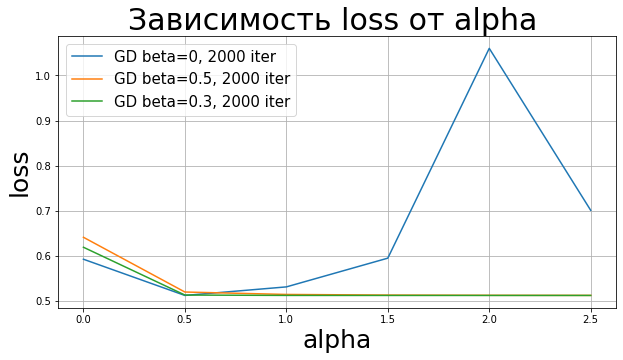

In [55]:
alps = np.arange(0.001, 3, 0.5)
y_a1 = []
y_a01 = []
y_a3 = []
aca_1 = []
aca_01 = []
aca_3 = []
for al in alps:
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.05, tolerance=0, max_iter=1000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a1.append(history)
    aca_1.append(clf.accuracy(x_test, y_test))
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.5, tolerance=0, max_iter=1000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a01.append(history)
    aca_01.append(clf.accuracy(x_test, y_test))
    
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.3, tolerance=0, max_iter=1000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a3.append(history)
    aca_3.append(clf.accuracy(x_test, y_test))


f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["func"][-1] for i in y_a1], label="GD beta=0, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a01], label="GD beta=0.5, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a3], label="GD beta=0.3, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от alpha ", fontsize=30)
ax.set_xlabel(u"alpha", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossalpha.pdf")

In [56]:
# f, ax = plt.subplots(1, figsize=(10, 5))
# ax.plot(alps, [i["func"][-1] for i in y_a1], label="GD beta=0, 2000 iter")
# ax.plot(alps, [i["func"][-1] for i in y_a01], label="GD beta=0.5, 2000 iter")
# ax.plot(alps, [i["func"][-1] for i in y_a3], label="GD beta=0.3, 2000 iter")
# #ax.plot(history_1['time'], history_1['func'], label="SGD")
# #ax2.plot(x, y2s, label="sgd")
# ax.set_title("Зависимость loss от alpha ", fontsize=20)
# ax.set_xlabel(u"alpha", fontsize=30)
# ax.set_ylabel(u"loss", fontsize=25)
# ax.grid()
# ax.legend(fontsize=15)
# plt.savefig("lossalpha.pdf")

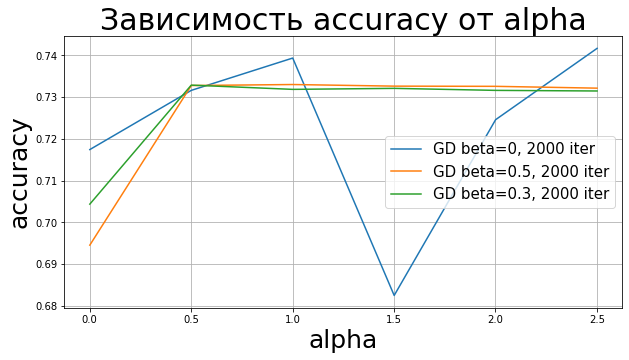

In [57]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, aca_1, label="GD beta=0, 2000 iter")
ax.plot(alps, aca_01, label="GD beta=0.5, 2000 iter")
ax.plot(alps, aca_3, label="GD beta=0.3, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от alpha", fontsize=30)
ax.set_xlabel(u"alpha", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("accalpha.pdf")

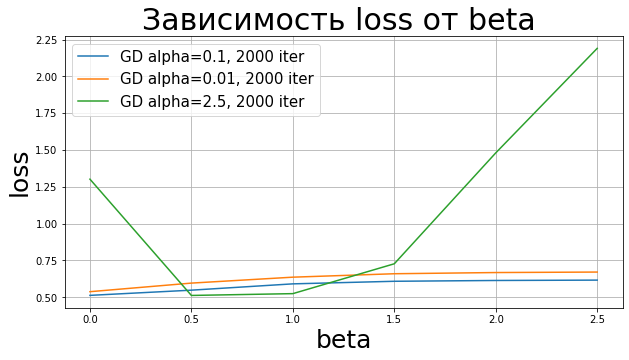

In [51]:
bets = np.arange(0, 3, 0.5)
y_b1 = []
y_b01 = []
y_b3 = []
ac_1 = []
ac_01 = []
ac_3 = []
for be in bets:
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.1,
                        step_beta=be, tolerance=0, max_iter=1000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_b1.append(history)
    ac_1.append(clf.accuracy(x_test, y_test))
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.01,
                        step_beta=be, tolerance=0, max_iter=1000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_b01.append(history)
    ac_01.append(clf.accuracy(x_test, y_test))
    clf = GDClassifier(loss_function='binary_logistic', step_alpha=2.5,
                        step_beta=be, tolerance=0, max_iter=1000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_b3.append(history)
    ac_3.append(clf.accuracy(x_test, y_test))


f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(bets, [i["func"][-1] for i in y_b1], label="GD alpha=0.1, 2000 iter")
ax.plot(bets, [i["func"][-1] for i in y_b01], label="GD alpha=0.01, 2000 iter")
ax.plot(bets, [i["func"][-1] for i in y_b3], label="GD alpha=2.5, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от beta ", fontsize=30)
ax.set_xlabel(u"beta", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossbeta.pdf")

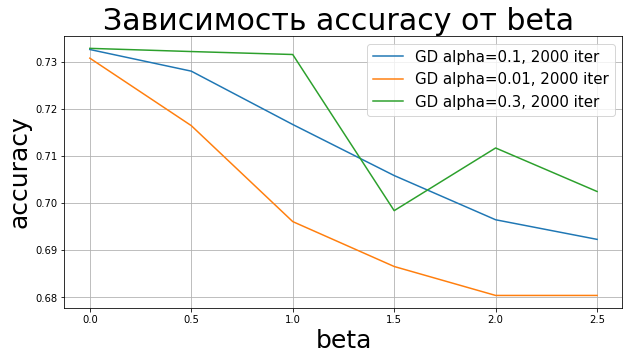

In [52]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(bets, ac_1, label="GD alpha=0.1, 2000 iter")
ax.plot(bets, ac_01, label="GD alpha=0.01, 2000 iter")
ax.plot(bets, ac_3, label="GD alpha=0.3, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от beta ", fontsize=30)
ax.set_xlabel(u"beta", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("betaacc.pdf")

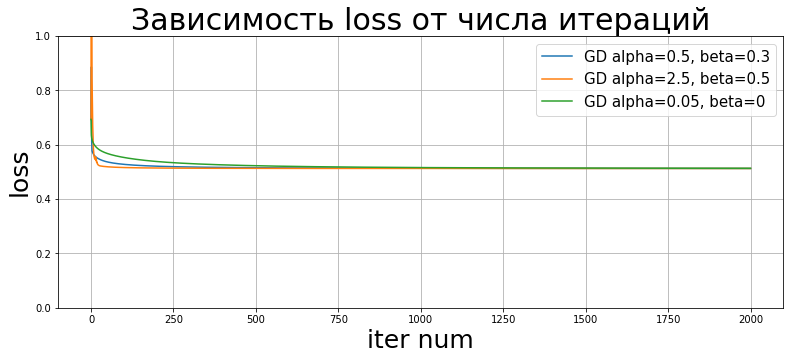

In [58]:
aca_1 = []
aca_2 = []
aca_3 = []
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=2000, batch_size=5, l2_coef=0, iter_acc=True)
history_0, aca_1 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=2.5,
                    step_beta=0.5, tolerance=0, max_iter=2000, batch_size=5, l2_coef=0, iter_acc=True)
history_1, aca_2 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.05,
                    step_beta=0, tolerance=0, max_iter=2000, batch_size=5, l2_coef=0, iter_acc=True)
history_2, aca_3 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)


f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(np.arange(0, len(history_0['time']))[:], history_0['func'][:], label="GD alpha=0.5, beta=0.3")
ax.plot(np.arange(0, len(history_1['time']))[:], history_1['func'][:], label="GD alpha=2.5, beta=0.5")
ax.plot(np.arange(0, len(history_2['time']))[:], history_2['func'][:], label="GD alpha=0.05, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от числа итераций", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossiter.pdf")

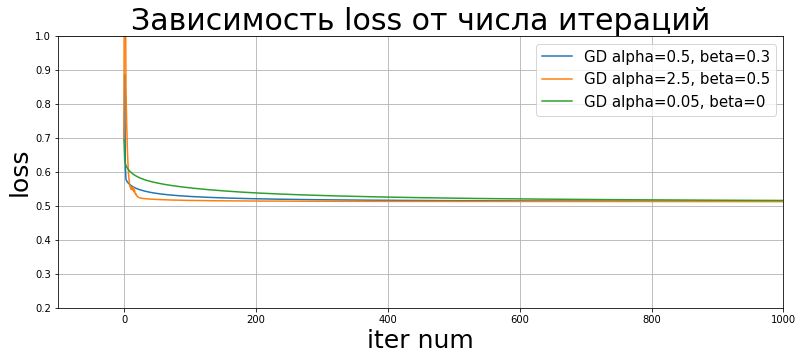

In [59]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(np.arange(0, len(history_0['time']))[:], history_0['func'][:], label="GD alpha=0.5, beta=0.3")
ax.plot(np.arange(0, len(history_1['time']))[:], history_1['func'][:], label="GD alpha=2.5, beta=0.5")
ax.plot(np.arange(0, len(history_2['time']))[:], history_2['func'][:], label="GD alpha=0.05, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от числа итераций", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0.2, 1)
ax.set_xlim(-100, 1000)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossiter.pdf")

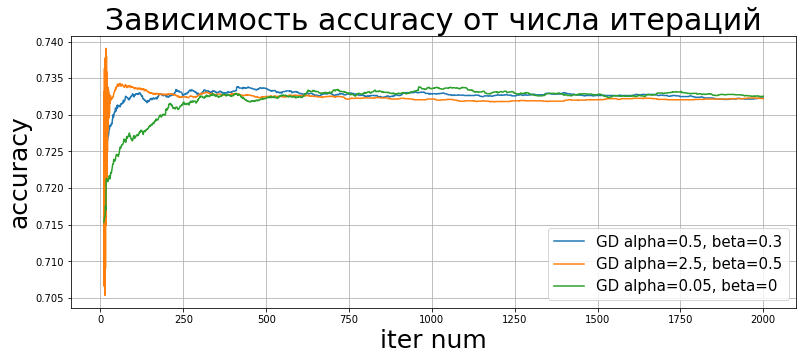

In [60]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(np.arange(0, len(history_0['time']))[10:], aca_1[10:], label="GD alpha=0.5, beta=0.3")
ax.plot(np.arange(0, len(history_1['time']))[10:], aca_2[10:], label="GD alpha=2.5, beta=0.5")
ax.plot(np.arange(0, len(history_2['time']))[10:], aca_3[10:], label="GD alpha=0.05, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от числа итераций", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("iteracc.pdf")

In [170]:
np.random.seed(127)
max_iter=50
l2_coef=0.1
step_alpha=1
step_beta=0
tolerance=0
# clf = optimization.GDClassifier(loss_function='binary_logistic', step_alpha=1,
#     step_beta=0, tolerance=1e-4, max_iter=5, l2_coef=0.1)
l, d = 1000, 10
X = np.random.random((l, d))
y = np.random.randint(0, 2, l) * 2 - 1
w = np.random.random(d)
history = fit(X, y, w_0=np.zeros(d), trace=True, acc=True)
# print(' '.join([str(x) for x in history['func']]))
# print(' '.join([str(x) for x in history['acc']]))
print(history)
# accuracy(X, y)

[-0.00496962 -0.00859974 -0.01081144 -0.00385787 -0.00332069 -0.01484788
 -0.01103289 -0.00908652 -0.00252334 -0.00923648]
[-4.49528147e-03 -1.12079052e-02 -1.54581379e-02 -2.44521488e-03
 -1.40200658e-03 -2.29926501e-02 -1.58716162e-02 -1.22114163e-02
 -6.07069944e-05 -1.24648099e-02]
[-2.81951035e-03 -1.22018706e-02 -1.82676280e-02  4.65592346e-05
  1.55078462e-03 -2.88604148e-02 -1.88531475e-02 -1.36772038e-02
  3.33122121e-03 -1.40230803e-02]
[-0.00102472 -0.01273334 -0.02040019  0.00255757  0.00447773 -0.03367384
 -0.02114125 -0.01462305  0.00663577 -0.01505853]
[ 0.00063001 -0.01310924 -0.022184    0.0048427   0.00713694 -0.03780952
 -0.02306594 -0.01535871  0.00962628 -0.01588209]
[ 0.00209835 -0.01341442 -0.02372614  0.00686637  0.00949662 -0.04141541
 -0.02473569 -0.01597511  0.01227837 -0.01658423]
[ 0.00338703 -0.01367492 -0.02507315  0.00864437  0.01157624 -0.04457348
 -0.02619819 -0.01650447  0.01461652 -0.01719654]
[ 0.00451431 -0.01390088 -0.0262534   0.01020286  0.01340

In [61]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()

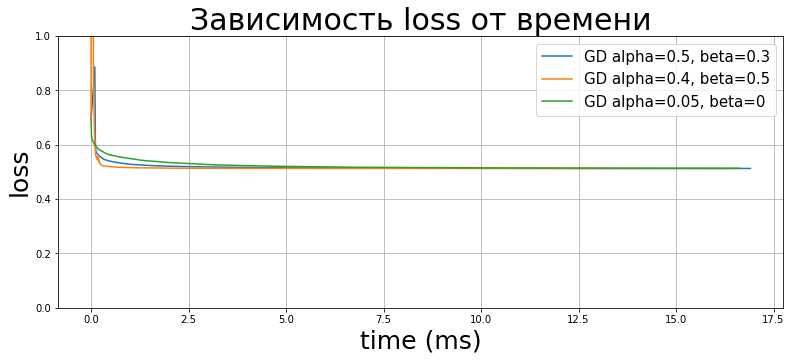

In [62]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'][:2000] /3, history_0['func'][:2000], label="GD alpha=0.5, beta=0.3")
ax.plot(history_1['time'][:2000]/ 3, history_1['func'][:2000], label="GD alpha=0.4, beta=0.5")
ax.plot(history_2['time'][:2000] / 3, history_2['func'][:2000], label="GD alpha=0.05, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 1)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("losstime1.pdf")

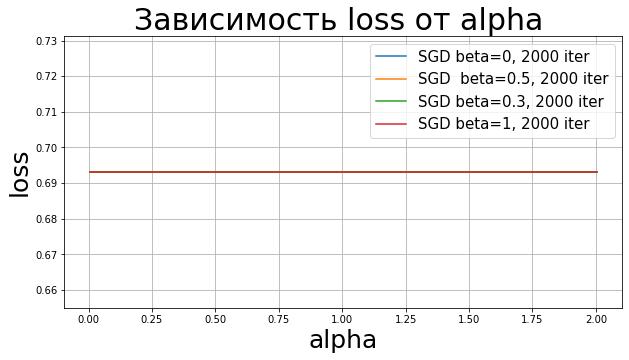

In [82]:
alps = np.arange(0.005, 2.5, 0.5)
y_a1 = []
y_a01 = []
y_a3 = []
y_a4 = []
aca_1 = []
aca_01 = []
aca_3 = []
aca_4 = []
for al in alps:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a1.append(history)
    aca_1.append(clf.accuracy(x_test, y_test))
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.5, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a01.append(history)
    aca_01.append(clf.accuracy(x_test, y_test))
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=0.3, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a3.append(history)
    aca_3.append(clf.accuracy(x_test, y_test))
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=al,
                        step_beta=1, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_a4.append(history)
    aca_4.append(clf.accuracy(x_test, y_test))


f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["func"][-1] for i in y_a1], label="SGD beta=0, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a01], label="SGD  beta=0.5, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a3], label="SGD beta=0.3, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a4], label="SGD beta=1, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от alpha ", fontsize=30)
ax.set_xlabel(u"alpha", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossalphasta.pdf")

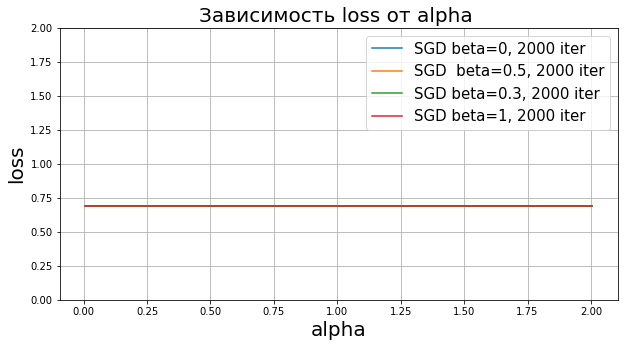

In [69]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, [i["func"][-1] for i in y_a1], label="SGD beta=0, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a01], label="SGD  beta=0.5, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a3], label="SGD beta=0.3, 2000 iter")
ax.plot(alps, [i["func"][-1] for i in y_a4], label="SGD beta=1, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от alpha ", fontsize=20)
ax.set_xlabel(u"alpha", fontsize=20)
ax.set_ylabel(u"loss", fontsize=20)
ax.set_ylim(0, 2)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossalphasta.pdf")

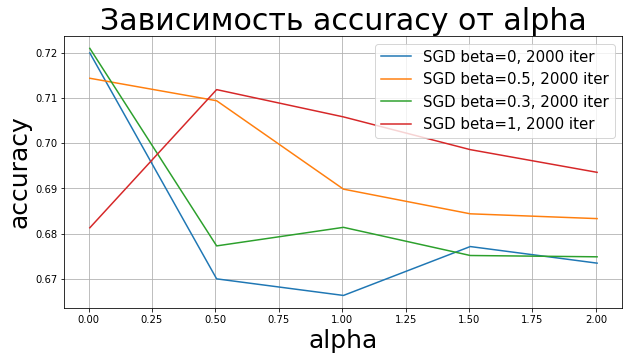

In [71]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(alps, aca_1, label="SGD beta=0, 2000 iter")
ax.plot(alps, aca_01, label="SGD beta=0.5, 2000 iter")
ax.plot(alps, aca_3, label="SGD beta=0.3, 2000 iter")
ax.plot(alps, aca_4, label="SGD beta=1, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от alpha", fontsize=30)
ax.set_xlabel(u"alpha", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("alpaccsta.pdf")

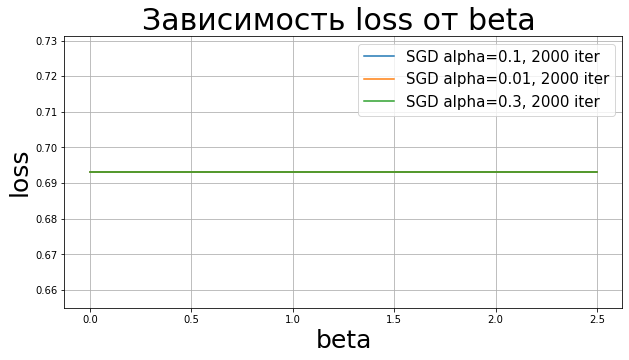

In [72]:
bets = np.arange(0, 3, 0.5)
y_b1 = []
y_b01 = []
y_b3 = []
ac_1 = []
ac_01 = []
ac_3 = []
for be in bets:
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.1,
                        step_beta=be, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_b1.append(history)
    ac_1.append(clf.accuracy(x_test, y_test))
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.01,
                        step_beta=be, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_b01.append(history)
    ac_01.append(clf.accuracy(x_test, y_test))
    clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                        step_beta=be, tolerance=0, max_iter=2000,batch_size=5, l2_coef=0)
    history = clf.fit(x_train, y_train, trace=True)
    y_b3.append(history)
    ac_3.append(clf.accuracy(x_test, y_test))


f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(bets, [i["func"][-1] for i in y_b1], label="SGD alpha=0.1, 2000 iter")
ax.plot(bets, [i["func"][-1] for i in y_b01], label="SGD alpha=0.01, 2000 iter")
ax.plot(bets, [i["func"][-1] for i in y_b3], label="SGD alpha=0.3, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от beta ", fontsize=30)
ax.set_xlabel(u"beta", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossbetasta.pdf")

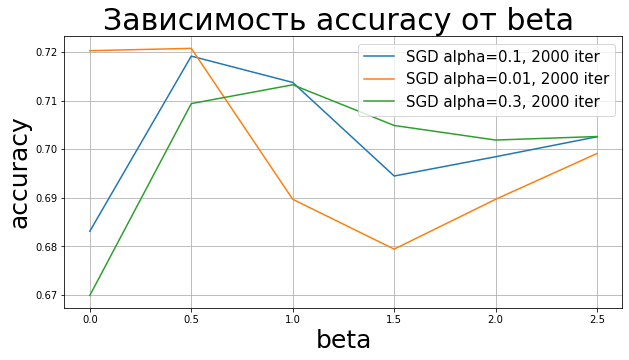

In [73]:
f, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(bets, ac_1, label="SGD alpha=0.1, 2000 iter")
ax.plot(bets, ac_01, label="SGD alpha=0.01, 2000 iter")
ax.plot(bets, ac_3, label="SGD alpha=0.3, 2000 iter")
#ax.plot(history_1['time'], history_1['func'], label="SGD")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от beta ", fontsize=30)
ax.set_xlabel(u"beta", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("betaccsta.pdf")

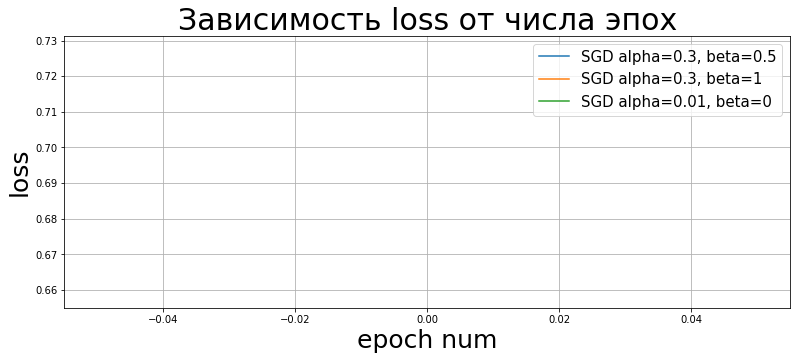

In [74]:
aca_1 = []
aca_2 = []
aca_3 = []
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_0, aca_1 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=1, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_1, aca_2 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.01,
                    step_beta=0, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_2, aca_3 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)


f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['epoch_num'], history_0['func'], label="SGD alpha=0.3, beta=0.5")
ax.plot(history_1['epoch_num'], history_1['func'], label="SGD alpha=0.3, beta=1")
ax.plot(history_2['epoch_num'], history_2['func'], label="SGD alpha=0.01, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("lossitersta.pdf")

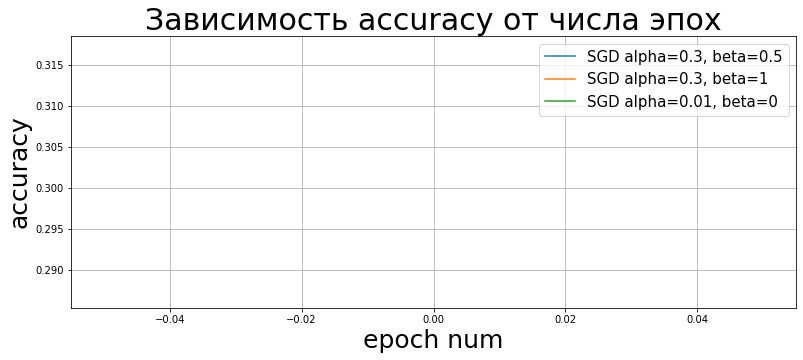

In [75]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['epoch_num'], aca_1, label="SGD alpha=0.3, beta=0.5")
ax.plot(history_1['epoch_num'], aca_2, label="SGD alpha=0.3, beta=1")
ax.plot(history_2['epoch_num'], aca_3, label="SGD alpha=0.01, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость accuracy от числа эпох", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"accuracy", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("iteraccsta.pdf")

In [76]:
history_0['time'] = np.array(history_0['time']).cumsum()
history_1['time'] = np.array(history_1['time']).cumsum()
history_2['time'] = np.array(history_2['time']).cumsum()

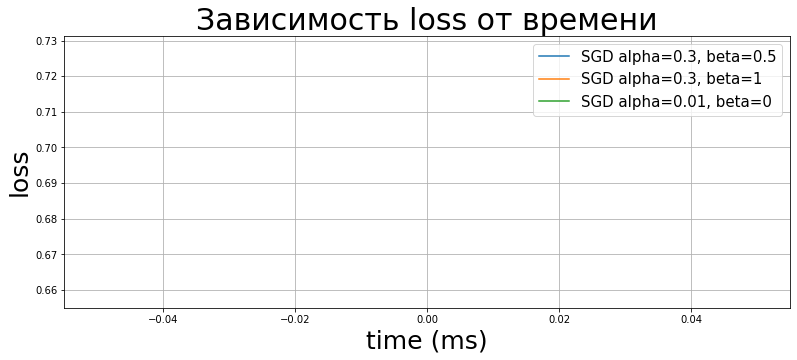

In [77]:
f, ax = plt.subplots(1, figsize=(13, 5))
ax.plot(history_0['time'] /3, history_0['func'], label="SGD alpha=0.3, beta=0.5")
ax.plot(history_1['time']/ 3, history_1['func'], label="SGD alpha=0.3, beta=1")
ax.plot(history_2['time'] / 3, history_2['func'], label="SGD alpha=0.01, beta=0")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от времени", fontsize=30)
ax.set_xlabel(u"time (ms)", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("losstimesta.pdf")

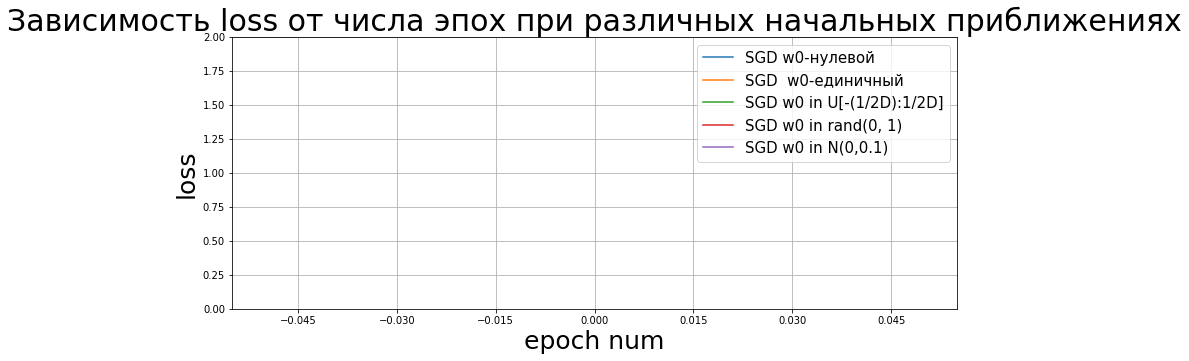

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

aca_1 = []
aca_2 = []
aca_3 = []
aca_4 = []
aca_5 = []
w_01 = np.ones(x_train.shape[1])
w_02 = np.random.uniform(-1/(2*x_train.shape[1]), 1/(2*x_train.shape[1]), size=x_train.shape[1])
w_03 = np.random.rand(x_train.shape[1])
w_04 = np.random.normal(0, 0.1, x_train.shape[1])
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_0, aca_1 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_1, aca_2 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_01)

clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_2, aca_3 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_02)
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_3, aca_5 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_03)
clf = SGDClassifier(loss_function='binary_logistic', step_alpha=0.3,
                    step_beta=0.5, tolerance=0, max_iter=10000, batch_size=5, l2_coef=0, iter_acc=True)
history_4, aca_5 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_04)

f, ax = plt.subplots(1, figsize=(13, 5))
f.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history_0['epoch_num'][:4], history_0['func'][:4], label="SGD w0-нулевой")
ax.plot(history_1['epoch_num'][:4], history_1['func'][:4], label="SGD  w0-единичный")
ax.plot(history_2['epoch_num'][:4], history_2['func'][:4], label="SGD w0 in U[-(1/2D):1/2D]")
ax.plot(history_3['epoch_num'][:4], history_3['func'][:4], label="SGD w0 in rand(0, 1)")
ax.plot(history_4['epoch_num'][:4], history_4['func'][:4], label="SGD w0 in N(0,0.1)")
#ax2.plot(x, y2s, label="sgd")
ax.set_title("Зависимость loss от числа эпох при различных начальных приближениях", fontsize=30)
ax.set_xlabel(u"epoch num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 2)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("w0sta.pdf")

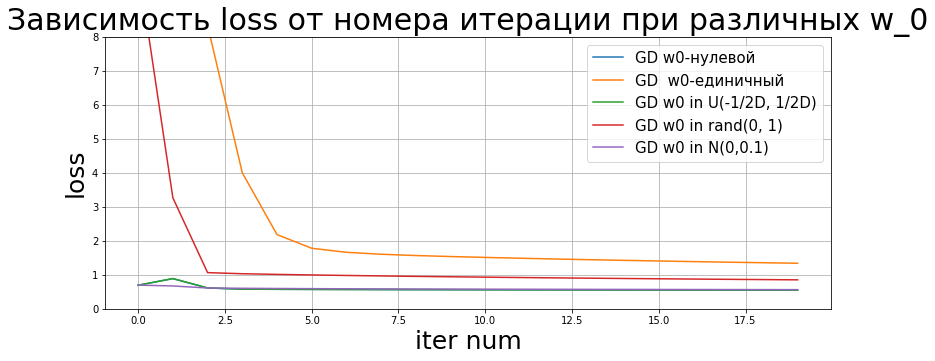

In [79]:
aca_1 = []
aca_2 = []
aca_3 = []
aca_4 = []
aca_5 = []
w_01 = np.ones(x_train.shape[1])
w_02 = np.random.uniform(-1/(2*x_train.shape[1]), 1/(2*x_train.shape[1]), size=x_train.shape[1])
w_03 = np.random.rand(x_train.shape[1])
w_04 = np.random.normal(0, 0.1, x_train.shape[1])
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=500, batch_size=5, l2_coef=0, iter_acc=True)
history_0, aca_1 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=500, batch_size=5, l2_coef=0, iter_acc=True)
history_1, aca_2 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_01)

clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=500, batch_size=5, l2_coef=0, iter_acc=True)
history_2, aca_3 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_02)
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=500, batch_size=5, l2_coef=0, iter_acc=True)
history_3, aca_4 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_03)
clf = GDClassifier(loss_function='binary_logistic', step_alpha=0.5,
                    step_beta=0.3, tolerance=0, max_iter=500, batch_size=5, l2_coef=0, iter_acc=True)
history_4, aca_5 = clf.fit(x_train, y_train, trace=True, x_test=x_test, y_test=y_test, w_0=w_04)

f, ax = plt.subplots(1, figsize=(13, 5))
f.gca()
ax.plot(np.arange(0, len(history_0['time']))[:20], history_0['func'][:20], label="GD w0-нулевой")
ax.plot(np.arange(0, len(history_0['time']))[:20], history_1['func'][:20], label="GD  w0-единичный")
ax.plot(np.arange(0, len(history_0['time']))[:20], history_2['func'][:20], label="GD w0 in U(-1/2D, 1/2D)")
ax.plot(np.arange(0, len(history_0['time']))[:20], history_3['func'][:20], label="GD w0 in rand(0, 1)")
ax.plot(np.arange(0, len(history_0['time']))[:20], history_4['func'][:20], label="GD w0 in N(0,0.1)")
ax.set_title("Зависимость loss от номера итерации при различных w_0", fontsize=30)
ax.set_xlabel(u"iter num", fontsize=25)
ax.set_ylabel(u"loss", fontsize=25)
ax.set_ylim(0, 8)
ax.grid()
ax.legend(fontsize=15)
plt.savefig("w0.pdf")